Крок 1. Завантаження данних Autos

### Знайомство з даними

In [1]:
import warnings
import pickle
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

# %%
concrete = datasets['concrete']
# Перегляд перших кількох рядків датасету concrete
concrete = datasets['concrete']
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Крок 2. Створення нової ознаки

In [2]:
# Крок 2: Створення нової ознаки Count, яка вказує на кількість задіяних складових у різних рецептурах бетону
concrete['Count'] = (concrete.iloc[:, :-2] > 0).sum(axis=1)


Крок 3. Нормалізація даних за допомогою об’єкта StandardScaler з пакета sklearn для подальшої кластеризації.

In [3]:
# Крок 3: Нормалізація набору даних
scaler = StandardScaler()
scaled_features = scaler.fit_transform(concrete.iloc[:, :-3])


Крок 4. Визначення оптимальну кількість кластерів за допомогою об'єкта KElbowVisualizer з пакета yellowbrick

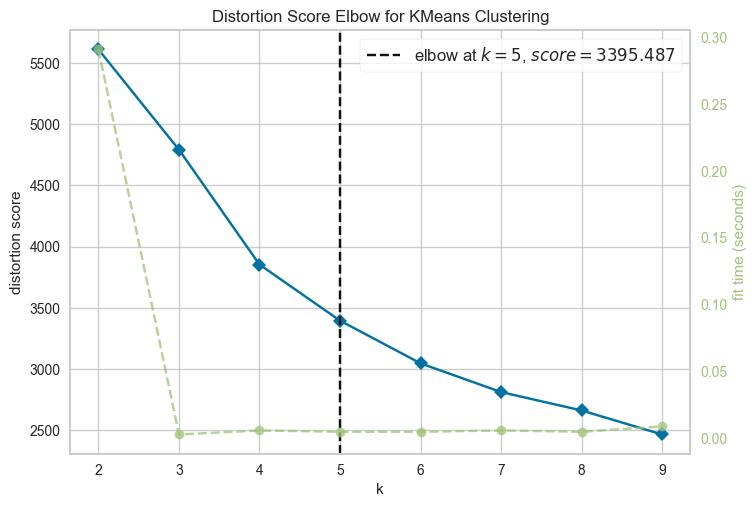

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
# Крок 4: Визначення оптимальної кількості кластерів методом "ліктя"
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(scaled_features)
visualizer.show()


In [5]:
# Визначимо оптимальну кількість кластерів з графіку
optimal_clusters = visualizer.elbow_value_

Крок 5. Кластеризація методом k-середніх і отримання мітки для кількості кластерів, визначеної на попередньому кроці.

In [6]:
# Крок 5: Проведення кластеризації методом KMeans
kmeans = KMeans(n_clusters=optimal_clusters)
# Додаємо мітки кластерів до оригінального датасету
concrete['Cluster'] = kmeans.fit_predict(scaled_features)

Крок 6. Розрахунок медіани для кожної ознаки, включаючи підрахунок кількості компонент по кожному кластеру за допомогою методу groupby

In [7]:
cluster_summary = concrete.groupby('Cluster').median()
cluster_summary['Components'] = concrete.groupby('Cluster')['Count'].median()
cluster_summary['Count'] = concrete['Cluster'].value_counts()

#Крок 7: Додавання кількісті об'єктів (рецептур) у кожному з кластерів


In [8]:
cluster_summary['RecipeCount'] = concrete['Cluster'].value_counts()

In [9]:
# Перевірка кількості колонок у таблиці
print(cluster_summary.columns)

Index(['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
       'CoarseAggregate', 'FineAggregate', 'Age', 'CompressiveStrength',
       'Count', 'Components', 'RecipeCount'],
      dtype='object')


Крок 8: Аналіз звіту та висновки

In [10]:
cluster_summary = cluster_summary.reset_index()
cluster_summary.columns = ['Cluster', 'Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
                           'CoarseAggregate', 'FineAggregate', 'Age', 'CompressiveStrength', 'Components', 'Count', 'RecipeCount']

# Друк таблиці з результатами
print(cluster_summary)

   Cluster  Cement  BlastFurnaceSlag  FlyAsh  Water  Superplasticizer  \
0        0   480.0               0.0     0.0  210.0               0.0   
1        1   190.0             175.1     0.0  192.0               0.0   
2        2   387.0             116.0     0.0  159.5              11.6   
3        3   318.5               0.0     0.0  192.0               0.0   
4        4   213.6               0.0   122.0  170.2               8.9   

   CoarseAggregate  FineAggregate   Age  CompressiveStrength  Components  \
0           932.00          613.0  28.0               43.940          83   
1           946.50          732.6  28.0               31.020         243   
2           926.10          797.1  28.0               55.050         174   
3          1013.10          789.0  28.0               25.180         186   
4          1006.25          792.6  28.0               32.875         344   

   Count  RecipeCount  
0    5.0           83  
1    5.0          243  
2    6.0          174  
3    4.0

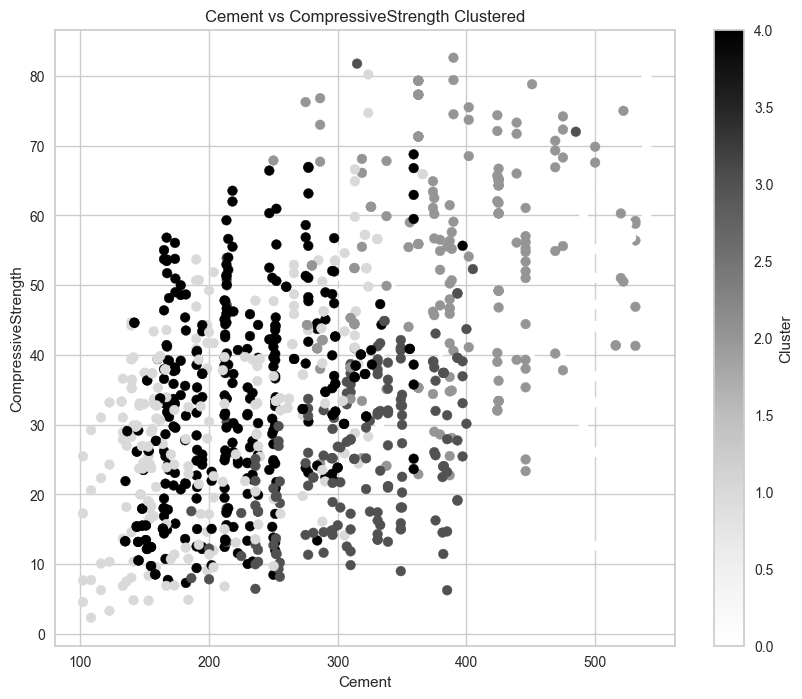

In [11]:
# Візуалізація для кращого розуміння
plt.figure(figsize=(10, 8))
plt.scatter(concrete['Cement'], concrete['CompressiveStrength'], c=concrete['Cluster'])
plt.xlabel('Cement')
plt.ylabel('CompressiveStrength')
plt.title('Cement vs CompressiveStrength Clustered')
plt.colorbar(label='Cluster')
plt.show()

# Аналіз:
Cluster 0:

* Середній вміст цементу: 186.2
* Високий вміст доменного шлаку: 183.20, відсутність золи
* Відсутність суперпластифікатора
* Вода: 192.00
* Низька міцність на стиск: 27.395
* Компоненти: 5.0
* Рецепт: 174

# Висновки:
Вплив компонентів на міцність:

* Cluster 2 має найвищу міцність на стиск (55.550), що зумовлено високим вмістом цементу та доменного шлаку, а також додаванням суперпластифікатора.
* Cluster 3 та Cluster 0 мають найнижчу міцність на стиск (27.630 і 27.395 відповідно), що може бути пов’язано з відсутністю суперпластифікатора та меншою кількістю компонентів.
* Вплив води на міцність:

* Cluster 5 має високий вміст води (228.00), але міцність на стиск все ще досить висока (41.885). Це вказує на те, що вміст води має вплив на міцність, але не є єдиним вирішальним фактором.

Роль суперпластифікатора:

* Кластери з додаванням суперпластифікатора (Cluster 1, Cluster 2, Cluster 4) мають середню або високу міцність на стиск. Це підкреслює важливість додавання суперпластифікатора для підвищення міцності бетону.

Оптимізація рецептур:

* Кластери з високою міцністю (Cluster 2, Cluster 5) можуть слугувати основою для оптимізації рецептів у кластерах з низькою міцністю (Cluster 0, Cluster 3), шляхом додавання суперпластифікатора або зміни співвідношення компонентів.

Баланс компонентів:

* Кластери з високою міцністю мають більш збалансовані рецепти з достатньою кількістю компонентів (6-7), що свідчить про важливість правильного балансу між цементом, доменним шлаком, золою та суперпластифікатором.